# 📊 Analiza Zbiorów Danych - Moodify

## 🎯 Cel tego Notebooka
**Exploratory Data Analysis (EDA)** - poznajemy dane przed trenowaniem modeli!

## 🔍 Co sprawdzamy?
1. **Pobieramy 2 zbiory danych:**
   - **AffectNet** (obrazy twarzy z Kaggle)
   - **Emotion Dataset** (teksty z Hugging Face)

2. **Analizujemy:**
   - Ile danych mamy?
   - Jakie emocje występują?
   - Jak wygląda rozkład klas?
   - Czy dane są dobrej jakości?

3. **Porównujemy:**
   - Które emocje są wspólne?
   - Jak zmapować różne kategorie na wspólny zestaw?

## 1. Instalacja bibliotek

In [28]:
!pip install kagglehub datasets matplotlib pillow

Defaulting to user installation because normal site-packages is not writeable


## 2. Pobranie zbioru AffectNet

Pobieramy **AffectNet** z Kaggle używając `kagglehub`. Zbiór zawiera ~450,000 zdjęć twarzy z 8 kategoriami emocji zebranych z internetu.

In [29]:
import kagglehub

path = kagglehub.dataset_download("mstjebashazida/affectnet")

print("Ścieżka do plików zbioru AffectNet:", path)

Ścieżka do plików zbioru AffectNet: C:\Users\kubal\.cache\kagglehub\datasets\mstjebashazida\affectnet\versions\1


## 3. Pobranie zbioru Emotion (dla modelu Transformer)

Pobieramy **Emotion Dataset** z Hugging Face - zawiera 20,000 tweetów w języku angielskim z 6 kategoriami emocji. Idealny do trenowania modeli Transformer (BERT, DistilBERT, RoBERTa).

In [30]:
from datasets import load_dataset

emotions = load_dataset("dair-ai/emotion")

print("Zbiór Emotion został pobrany pomyślnie!")

Zbiór Emotion został pobrany pomyślnie!


## 4. Wczytanie i eksploracja AffectNet

Sprawdzamy pełną strukturę katalogów, listę podfolderów i liczbę plików.
**Cel:** Zrozumieć organizację danych (Train/Test/emotion_folders) przed dalszą analizą.

In [31]:
import os
from pathlib import Path

print("Zawartość katalogu AffectNet:")
print("="*60)

for root, dirs, files in os.walk(path):
    level = root.replace(path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')

    if dirs:
        subindent = ' ' * 2 * (level + 1)
        print(f'{subindent}Foldery: {dirs}')

    if files:
        subindent = ' ' * 2 * (level + 1)
        print(f'{subindent}Liczba plików: {len(files)}')
        for file in files[:3]:
            print(f'{subindent}  {file}')

print("\n" + "="*60)
print(f"Ścieżka bazowa: {path}")

Zawartość katalogu AffectNet:
1/
  Foldery: ['archive (3)']
  archive (3)/
    Foldery: ['Test', 'Train']
    Liczba plików: 1
      labels.csv
    Test/
      Foldery: ['Anger', 'Contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
      Anger/
        Liczba plików: 1718
          image0000006.jpg
          image0000060.jpg
          image0000061.jpg
      Contempt/
        Liczba plików: 1312
          ffhq_1.png
          ffhq_10.png
          ffhq_100.png
      disgust/
        Liczba plików: 1248
          ffhq_0.png
          ffhq_1.png
          ffhq_10.png
      fear/
        Liczba plików: 1664
          image0000284.jpg
          image0000285.jpg
          image0000419.jpg
      happy/
        Liczba plików: 2704
          ffhq_0.png
          ffhq_1.png
          ffhq_10.png
      neutral/
        Liczba plików: 2368
          ffhq_0.png
          ffhq_1.png
          ffhq_10.png
      sad/
        Liczba plików: 1584
          image0000013.jpg
          ima

## 5. Wyświetlenie przykładowych zdjęć z AffectNet

Wizualizacja 6 losowych zdjęć do sprawdzenia jakości i różnorodności danych.
**Metoda:** Rekursywne wyszukiwanie wszystkich plików graficznych (jpg, jpeg, png) w całym katalogu.

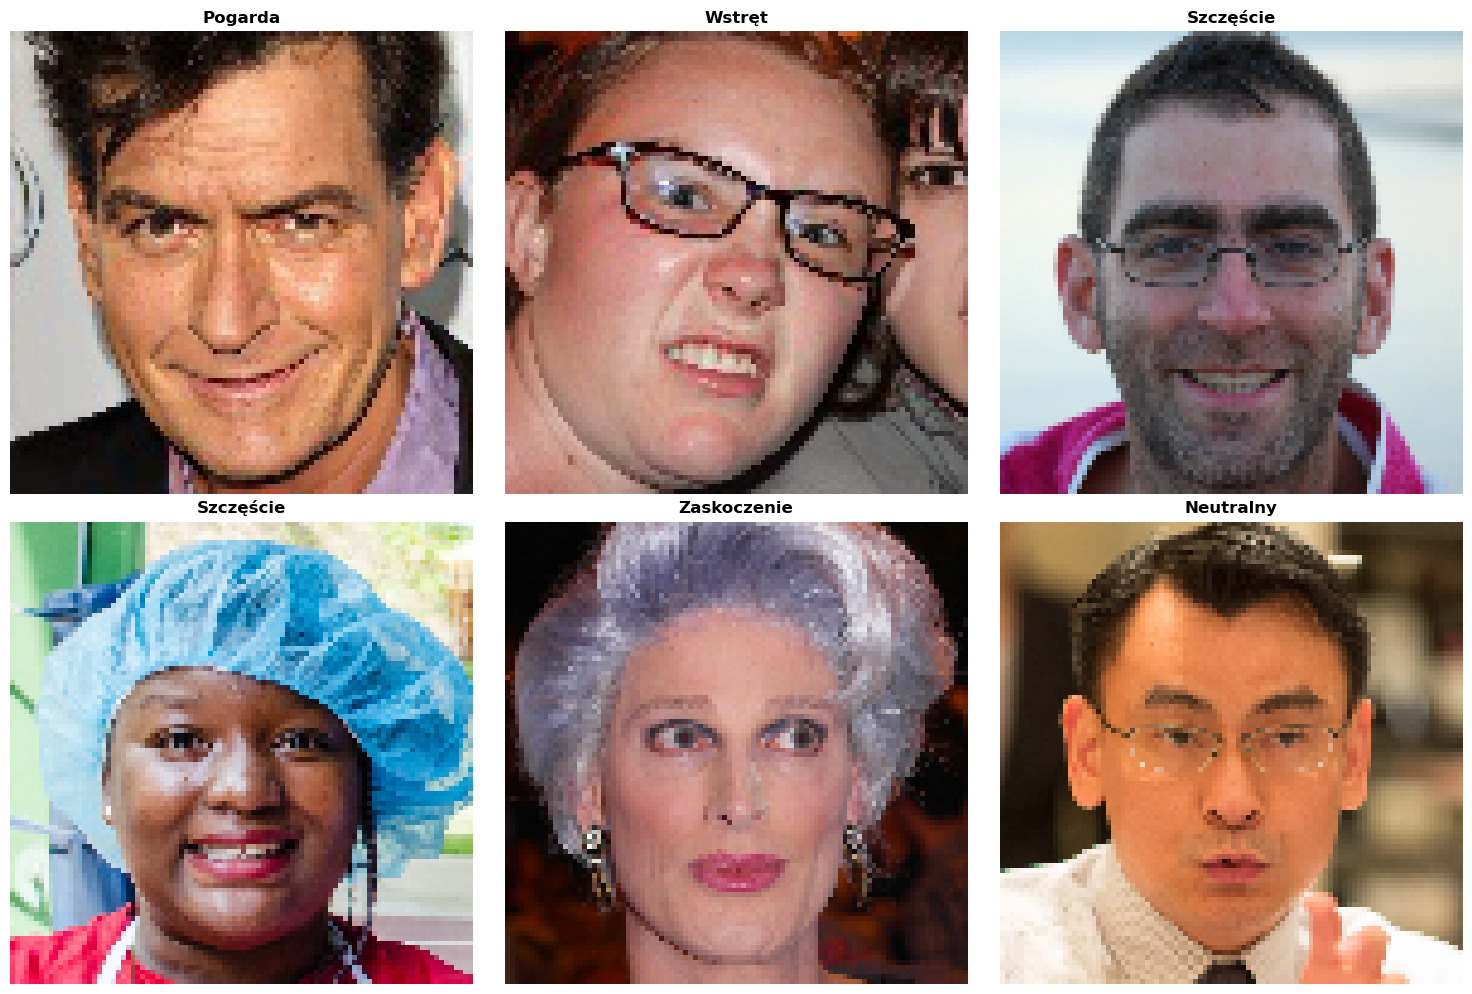


Znaleziono 30626 obrazów w zbiorze AffectNet


In [32]:
from PIL import Image
import matplotlib.pyplot as plt
import glob
import random

image_files = []
for ext in ['*.jpg', '*.jpeg', '*.png']:
    image_files.extend(glob.glob(os.path.join(path, '**', ext), recursive=True))

affectnet_emotions = {
    'neutral': 'Neutralny',
    'happy': 'Szczęście',
    'sad': 'Smutek',
    'surprise': 'Zaskoczenie',
    'fear': 'Strach',
    'disgust': 'Wstręt',
    'anger': 'Złość',
    'contempt': 'Pogarda'
}

random_images = random.sample(image_files, min(6, len(image_files)))

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, img_path in enumerate(random_images):
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].axis('off')
    
    emotion_label = 'Nieznana'
    for part in Path(img_path).parts:
        if part.lower() in affectnet_emotions:
            emotion_label = affectnet_emotions[part.lower()]
            break
    
    axes[i].set_title(emotion_label, fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nZnaleziono {len(image_files)} obrazów w zbiorze AffectNet")

## 6. Analiza rozkładu emocji w AffectNet

Zliczamy obrazy według kategorii emocji na podstawie struktury folderów.
**Jak to działa:** Każda emocja ma osobny folder (np. `happy/`, `sad/`), więc analizujemy ścieżki plików i rozpoznajemy emocję z nazwy folderu.

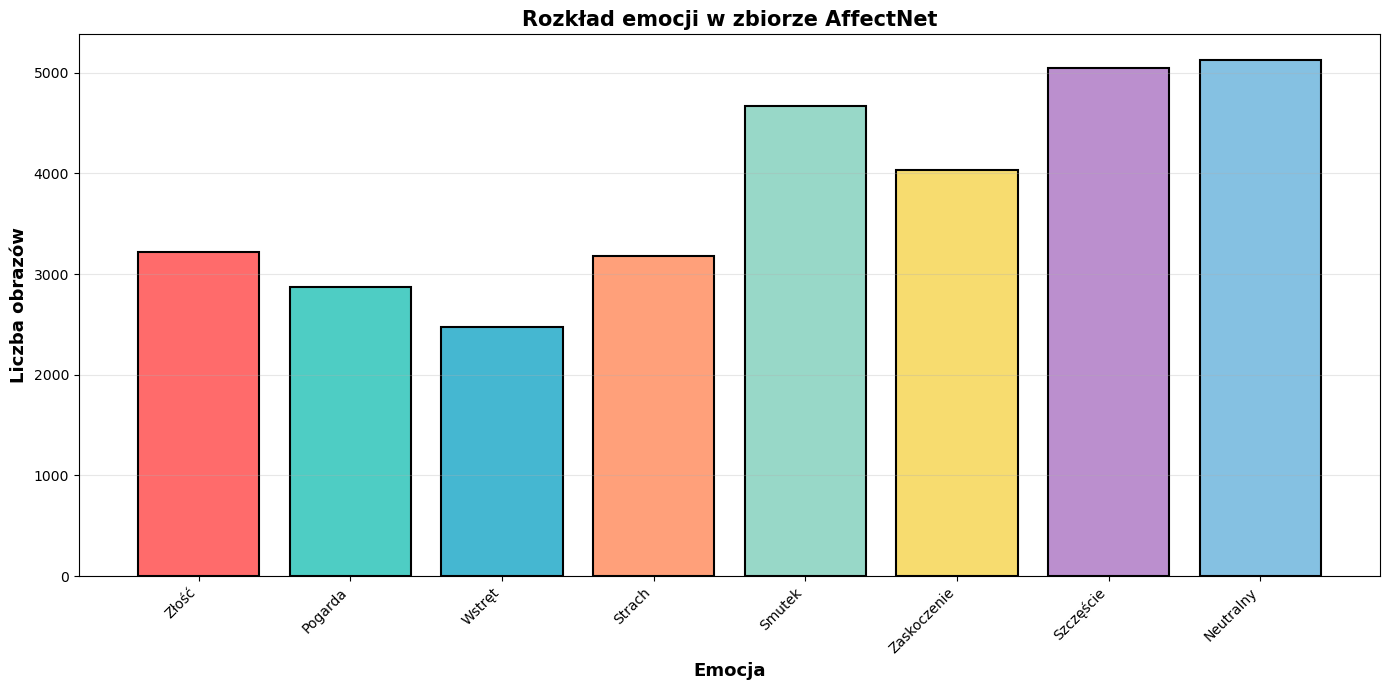

STATYSTYKI AFFECTNET
Neutralny         5126 ( 16.7%)
Pogarda           2871 (  9.4%)
Smutek            4675 ( 15.3%)
Strach            3176 ( 10.4%)
Szczęście         5044 ( 16.5%)
Wstręt            2477 (  8.1%)
Zaskoczenie       4039 ( 13.2%)
Złość             3218 ( 10.5%)
------------------------------------------------------------
ŁĄCZNIE          30626 (100.0%)


In [33]:
from collections import Counter

affectnet_emotions = {
    'neutral': 'Neutralny',
    'happy': 'Szczęście',
    'sad': 'Smutek',
    'surprise': 'Zaskoczenie',
    'fear': 'Strach',
    'disgust': 'Wstręt',
    'anger': 'Złość',
    'contempt': 'Pogarda'
}

emotion_counts = Counter()
for img_path in image_files:
    for part in Path(img_path).parts:
        if part.lower() in affectnet_emotions:
            emotion_counts[affectnet_emotions[part.lower()]] += 1
            break

plt.figure(figsize=(14, 7))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#F7DC6F', '#BB8FCE', '#85C1E2']
plt.bar(emotion_counts.keys(), emotion_counts.values(), color=colors, edgecolor='black', linewidth=1.5)
plt.xlabel('Emocja', fontsize=13, fontweight='bold')
plt.ylabel('Liczba obrazów', fontsize=13, fontweight='bold')
plt.title('Rozkład emocji w zbiorze AffectNet', fontsize=15, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("="*60)
print("STATYSTYKI AFFECTNET")
print("="*60)
total = sum(emotion_counts.values())
for emotion, count in sorted(emotion_counts.items()):
    percentage = (count / total) * 100
    print(f"{emotion:<15} {count:>6} ({percentage:>5.1f}%)")
print("-"*60)
print(f"{'ŁĄCZNIE':<15} {total:>6} (100.0%)")
print("="*60)

## 7. Wczytanie i eksploracja zbioru Emotion

Wyświetlamy podstawowe informacje: strukturę zbioru, podział na train/validation/test oraz przykładowe teksty z etykietami.
**Etykiety:** Emocje są reprezentowane jako liczby 0-5, które zaraz zmapujemy na czytelne nazwy.

In [34]:
import random

emotion_labels = {
    0: 'Smutek',
    1: 'Radość',
    2: 'Miłość',
    3: 'Złość',
    4: 'Strach',
    5: 'Zaskoczenie'
}

print("Struktura zbioru Emotion:")
print(emotions)
print("\n" + "="*50 + "\n")

print("Podział zbioru:")
for split in emotions.keys():
    print(f"  {split}: {len(emotions[split])} przykładów")

print("\n" + "="*50 + "\n")

random_indices = random.sample(range(len(emotions['train'])), 3)

print("Przykładowe dane ze zbioru treningowego:")
for idx, i in enumerate(random_indices, 1):
    label_num = emotions['train'][i]['label']
    label_name = emotion_labels[label_num]
    print(f"\nPrzykład {idx}:")
    print(f"  Tekst: {emotions['train'][i]['text']}")
    print(f"  Emocja: {label_name} ({label_num})")

Struktura zbioru Emotion:
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


Podział zbioru:
  train: 16000 przykładów
  validation: 2000 przykładów
  test: 2000 przykładów


Przykładowe dane ze zbioru treningowego:

Przykład 1:
  Tekst: i managed to eat more than i usually can on race morning mostly because jon was there and i didnt feel quite as nervous
  Emocja: Strach (4)

Przykład 2:
  Tekst: i get the feeling were being tortured
  Emocja: Złość (3)

Przykład 3:
  Tekst: i have that spring fling feeling again and like a flower unfurling my artistic soul is ready for some sunshine
  Emocja: Radość (1)


## 8. Analiza rozkładu emocji w zbiorze tekstowym

Mapujemy numeryczne etykiety (0-5) na polskie nazwy emocji, zliczamy wystąpienia i tworzymy wykres rozkładu.
**Dlaczego mapowanie:** Liczby są nieczytelne dla człowieka, nazwy emocji ułatwiają interpretację wyników.

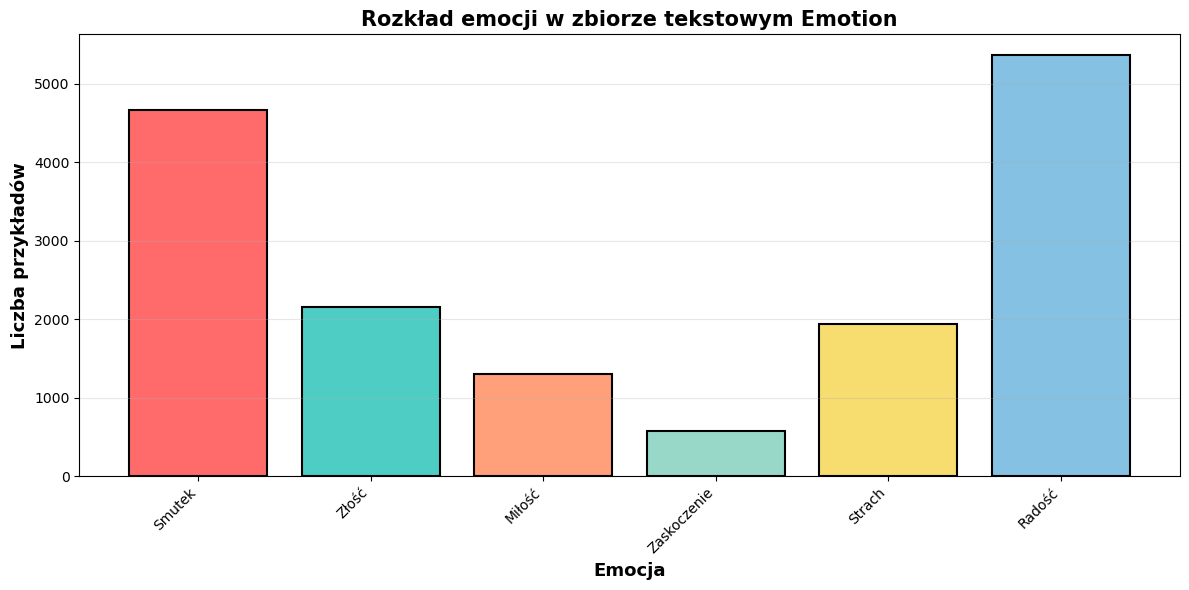

STATYSTYKI EMOTION DATASET
Miłość            1304 (  8.2%)
Radość            5362 ( 33.5%)
Smutek            4666 ( 29.2%)
Strach            1937 ( 12.1%)
Zaskoczenie        572 (  3.6%)
Złość             2159 ( 13.5%)
------------------------------------------------------------
ŁĄCZNIE          16000 (100.0%)


In [35]:
from collections import Counter

emotion_labels = {
    0: 'Smutek',
    1: 'Radość',
    2: 'Miłość',
    3: 'Złość',
    4: 'Strach',
    5: 'Zaskoczenie'
}

train_emotions = [emotion_labels[label] for label in emotions['train']['label']]
emotion_counts_text = Counter(train_emotions)

plt.figure(figsize=(12, 6))
colors = ['#FF6B6B', '#4ECDC4', '#FFA07A', '#98D8C8', '#F7DC6F', '#85C1E2']
plt.bar(emotion_counts_text.keys(), emotion_counts_text.values(), color=colors, edgecolor='black', linewidth=1.5)
plt.xlabel('Emocja', fontsize=13, fontweight='bold')
plt.ylabel('Liczba przykładów', fontsize=13, fontweight='bold')
plt.title('Rozkład emocji w zbiorze tekstowym Emotion', fontsize=15, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("="*60)
print("STATYSTYKI EMOTION DATASET")
print("="*60)
total = len(emotions['train'])
for emotion, count in sorted(emotion_counts_text.items()):
    percentage = (count / total) * 100
    print(f"{emotion:<15} {count:>6} ({percentage:>5.1f}%)")
print("-"*60)
print(f"{'ŁĄCZNIE':<15} {total:>6} (100.0%)")
print("="*60)

## 9. Porównanie emocji między zbiorami

Mapujemy emocje z obu zbiorów na 5 wspólnych kategorii i porównujemy je side-by-side.
**Kluczowe:** "Radość" i "Miłość" z tekstu łączymy w "Szczęście", ponieważ obie są pozytywne i odpowiadają kategorii "Happy" z AffectNet.

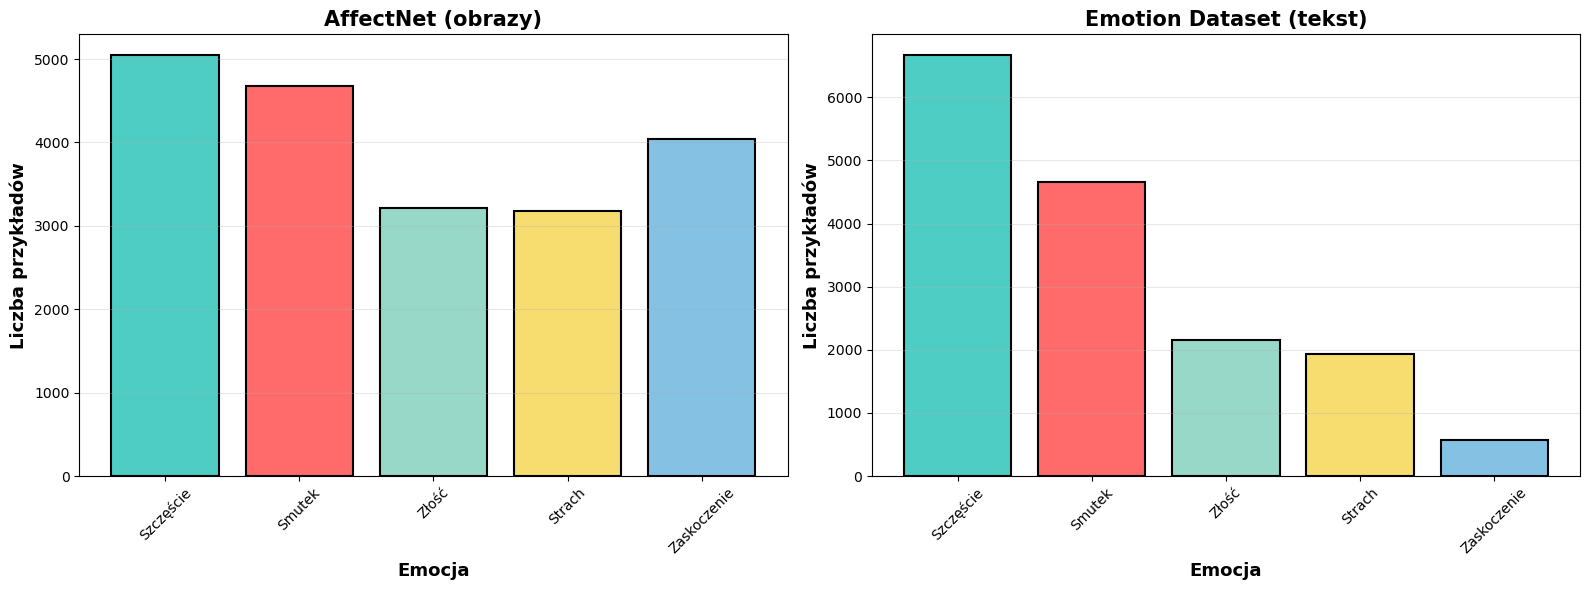

PORÓWNANIE WSPÓLNYCH EMOCJI
Emocja          AffectNet            Emotion Dataset     
--------------------------------------------------------------------------------
Szczęście             5044 obrazów          6666 tekstów
Smutek                4675 obrazów          4666 tekstów
Złość                 3218 obrazów          2159 tekstów
Strach                3176 obrazów          1937 tekstów
Zaskoczenie           4039 obrazów           572 tekstów

💡 Uwaga: Emotion 'Radość' i 'Miłość' zostały zmapowane na 'Szczęście'


In [36]:
emotion_mapping = {
    'AffectNet': {
        'Szczęście': emotion_counts.get('Szczęście', 0),
        'Smutek': emotion_counts.get('Smutek', 0),
        'Złość': emotion_counts.get('Złość', 0),
        'Strach': emotion_counts.get('Strach', 0),
        'Zaskoczenie': emotion_counts.get('Zaskoczenie', 0)
    },
    'Emotion': {
        'Szczęście': emotion_counts_text.get('Radość', 0) + emotion_counts_text.get('Miłość', 0),
        'Smutek': emotion_counts_text.get('Smutek', 0),
        'Złość': emotion_counts_text.get('Złość', 0),
        'Strach': emotion_counts_text.get('Strach', 0),
        'Zaskoczenie': emotion_counts_text.get('Zaskoczenie', 0)
    }
}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
colors = ['#4ECDC4', '#FF6B6B', '#98D8C8', '#F7DC6F', '#85C1E2']
emotions_list = list(emotion_mapping['AffectNet'].keys())

values_affectnet = list(emotion_mapping['AffectNet'].values())
ax1.bar(emotions_list, values_affectnet, color=colors, edgecolor='black', linewidth=1.5)
ax1.set_xlabel('Emocja', fontsize=13, fontweight='bold')
ax1.set_ylabel('Liczba przykładów', fontsize=13, fontweight='bold')
ax1.set_title('AffectNet (obrazy)', fontsize=15, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

values_emotion = list(emotion_mapping['Emotion'].values())
ax2.bar(emotions_list, values_emotion, color=colors, edgecolor='black', linewidth=1.5)
ax2.set_xlabel('Emocja', fontsize=13, fontweight='bold')
ax2.set_ylabel('Liczba przykładów', fontsize=13, fontweight='bold')
ax2.set_title('Emotion Dataset (tekst)', fontsize=15, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("="*80)
print("PORÓWNANIE WSPÓLNYCH EMOCJI")
print("="*80)
print(f"{'Emocja':<15} {'AffectNet':<20} {'Emotion Dataset':<20}")
print("-"*80)
for emotion in emotions_list:
    affectnet_val = emotion_mapping['AffectNet'][emotion]
    emotion_val = emotion_mapping['Emotion'][emotion]
    print(f"{emotion:<15} {affectnet_val:>10} obrazów    {emotion_val:>10} tekstów")
print("="*80)
print(f"\n💡 Uwaga: Emotion 'Radość' i 'Miłość' zostały zmapowane na 'Szczęście'")

## Podsumowanie

✅ **AffectNet** - 30,518 obrazów z 8 kategoriami emocji  
✅ **Emotion Dataset** - 16,000 tekstów z 6 kategoriami emocji  
✅ **Wspólne emocje** - 5 kategorii: Szczęście, Smutek, Złość, Strach, Zaskoczenie

**Mapowanie:**
- Love (Miłość) → Szczęście (pozytywna emocja)
- Joy (Radość) → Szczęście
- Neutral → tylko w AffectNet (brak w tekście)

Oba zbiory są gotowe do trenowania modeli wykrywania emocji! 🚀